In [1]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense
from sklearn.metrics import confusion_matrix, classification_report, f1_score


# Step 1: Load and preprocess the dataset
def preprocess_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (224, 224))  # Resize to match ResNet50 input size
    return img

# Load dataset
dataset_dir = "Traffic_dataset24"
class_names = [class_name for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name))]

# Create a list of file paths and their corresponding labels
file_paths = []
labels = []
for class_name in class_names:
    class_dir = os.path.join(dataset_dir, class_name)
    class_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.png') or file.endswith('.jpg')]
    file_paths.extend(class_files)
    labels.extend([class_name] * len(class_files))

# Convert class names to integer labels
label_to_index = {class_name: i for i, class_name in enumerate(class_names)}
labels = [label_to_index[label] for label in labels]

# Preprocess images and create TensorFlow Dataset
images_ds = tf.data.Dataset.from_tensor_slices(file_paths)
labels_ds = tf.data.Dataset.from_tensor_slices(labels)
dataset = tf.data.Dataset.zip((images_ds, labels_ds))

# Shuffle and batch the dataset
batch_size = 32  # Define your batch size here
dataset = dataset.shuffle(buffer_size=len(file_paths))
dataset = dataset.map(lambda x, y: (preprocess_image(x), y))
dataset = dataset.batch(batch_size)

# Step 2: Build the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
output = Dense(len(class_names), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Step 3: Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Step 4: Train the model
epochs = 10
model.fit(dataset, epochs=epochs)




C:\Users\Prem Prakash\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1048s 10s/step - accuracy: 0.8096 - loss: 4.0972
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 719s 8s/step - accuracy: 0.8512 - loss: 1.6137
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 635s 7s/step - accuracy: 0.8542 - loss: 1.0078
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1976s 21s/step - accuracy: 0.8555 - loss: 1.1362
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 572s 6s/step - accuracy: 0.8610 - loss: 0.8258
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 703s 7s/step - accuracy: 0.8352 - loss: 1.2307
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 672s 7s/step - accuracy: 0.8372 - loss: 0.9607
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 716s 8s/step - accuracy: 0.8483 - loss: 0.8400
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 651s 7s/step - accuracy: 0.8636 - loss: 0.5766
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 719s 8s/step - accuracy: 0.8628 - loss: 0.6307


In [2]:
# Load and preprocess the test dataset similarly to the training dataset
test_dataset_dir = "Traffic_dataset24"
test_file_paths = []
test_labels = []

for class_name in class_names:
    class_dir = os.path.join(test_dataset_dir, class_name)
    class_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith('.png') or file.endswith('.jpg')]
    test_file_paths.extend(class_files)
    test_labels.extend([class_name] * len(class_files))

test_labels = [label_to_index[label] for label in test_labels]

test_images_ds = tf.data.Dataset.from_tensor_slices(test_file_paths)
test_labels_ds = tf.data.Dataset.from_tensor_slices(test_labels)
test_dataset = tf.data.Dataset.zip((test_images_ds, test_labels_ds))

test_dataset = test_dataset.map(lambda x, y: (preprocess_image(x), y))
test_dataset = test_dataset.batch(batch_size)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test accuracy:", test_accuracy)


94/94 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.6061 - loss: 0.7198
Test accuracy: 0.8666666746139526


94/94 ━━━━━━━━━━━━━━━━━━━━ 416s 4s/step
Confusion Matrix:
[[   0  400]
 [   0 2600]]
F1-score: 0.8047619047619048


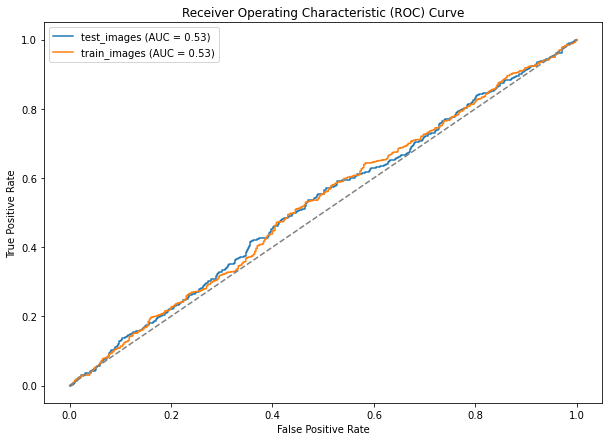

In [3]:

# Predict on test dataset
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = []
for _, label in test_dataset:
    true_labels.extend(label.numpy())

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)


# F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1-score:", f1)

# Calculate ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 8211s 88s/step - accuracy: 0.6061 - loss: 0.7198
Test accuracy: 0.8666666746139526
94/94 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step


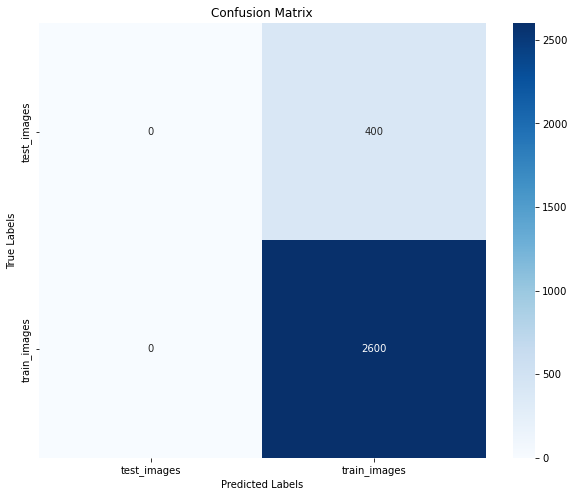

Classification Report:
              precision    recall  f1-score   support

 test_images       0.00      0.00      0.00       400
train_images       0.87      1.00      0.93      2600

    accuracy                           0.87      3000
   macro avg       0.43      0.50      0.46      3000
weighted avg       0.75      0.87      0.80      3000

F1-score: 0.8047619047619048


C:\Users\Prem Prakash\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Prem Prakash\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Prem Prakash\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


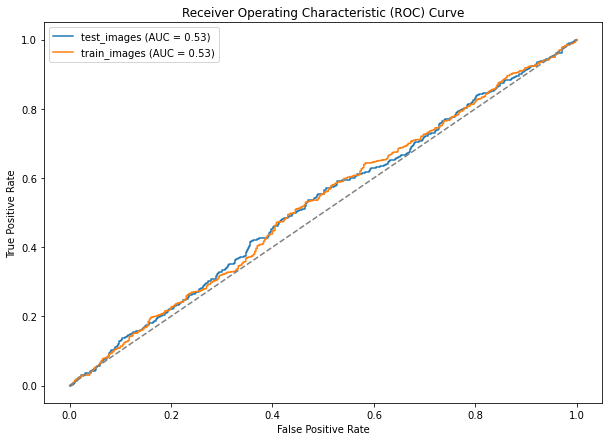

In [4]:

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print("Test accuracy:", test_accuracy)

# Predict on test dataset
predictions = model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# True labels
true_labels = []
for _, label in test_dataset:
    true_labels.extend(label.numpy())

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

# F1-score
f1 = f1_score(true_labels, predicted_labels, average='weighted')
print("F1-score:", f1)

# Calculate ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(np.array(true_labels) == i, predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 7))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
